In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### **Section 1: Setup**

In [2]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


In [23]:
# !pip install google-adk
from google.genai import types
from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search, AgentTool, ToolContext
from google.adk.code_executors import BuiltInCodeExecutor

print("ADK component imported!!!")


ADK component imported!!!


In [4]:
retry_config=types.HttpRetryOptions(
    attempts=5,
    exp_base=7,
    initial_delay=1,
    http_status_codes=[429,500,503,504]
)

In [24]:
# Helper function that prints the generated Python code and results from the code execution tool:
def show_python_code_and_result(response):
    for i in range(len(response)):
        # Check if the response contains a valid function call result from the code executor
        if (
            (response[i].content.parts)
            and (response[i].content.parts[0])
            and (response[i].content.parts[0].function_response)
            and (response[i].content.parts[0].function_response.response)
        ):
            response_code = response[i].content.parts[0].function_response.response
            if "result" in response_code and response_code["result"] != "```":
                if "tool_code" in response_code["result"]:
                    print(
                        "Generated Python Code >> ",
                        response_code["result"].replace("tool_code", ""),
                    )
                else:
                    print("Generated Python Response >> ", response_code["result"])

print("Helper functions defined.")

Helper functions defined.


## **Building Custom Function Tools**


## **Currency Converter Agent**

This agent can convert currency from one denomination to another and calculates the fees to do the conversion. The agent has two custom tools and follows the workflow:

- Fee Lookup Tool - Finds transaction fees for the conversion (mock)
- Exchange Rate Tool - Gets currency conversion rates (mock)
- Calculation Step - Calculates the total conversion cost including the fees

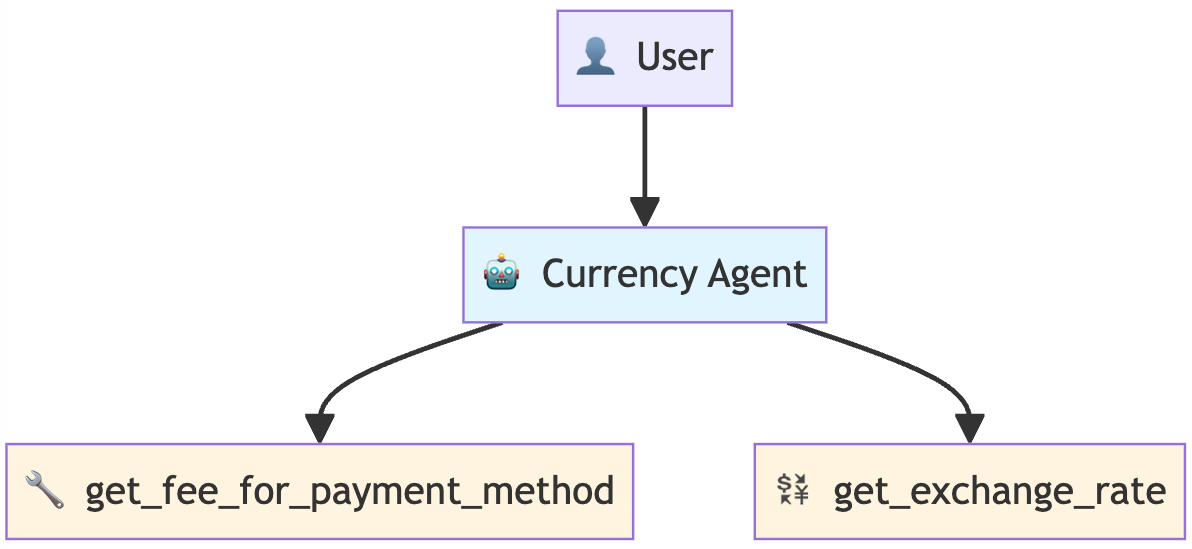
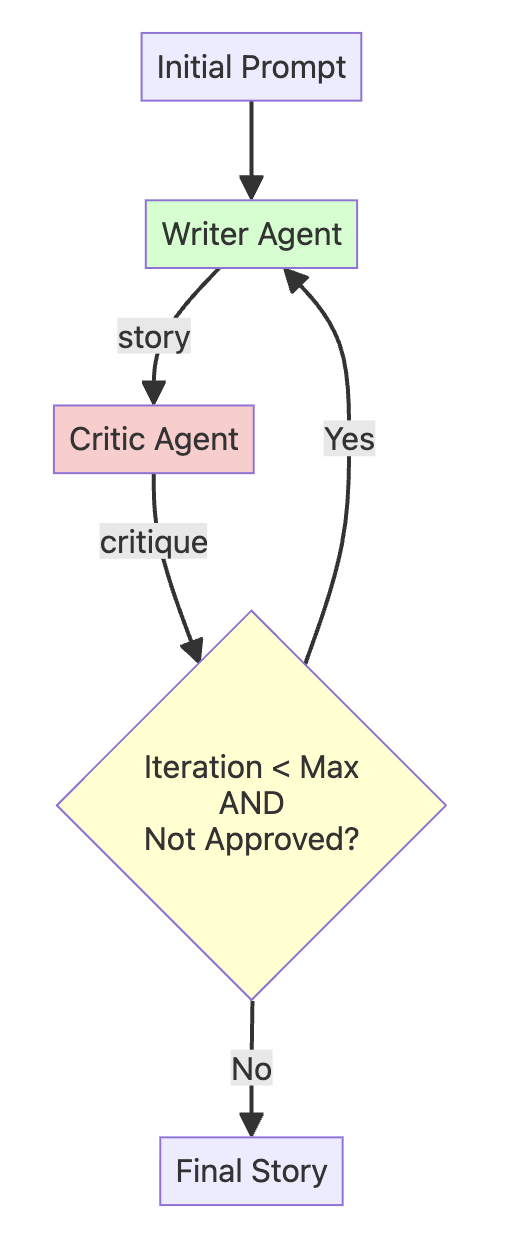
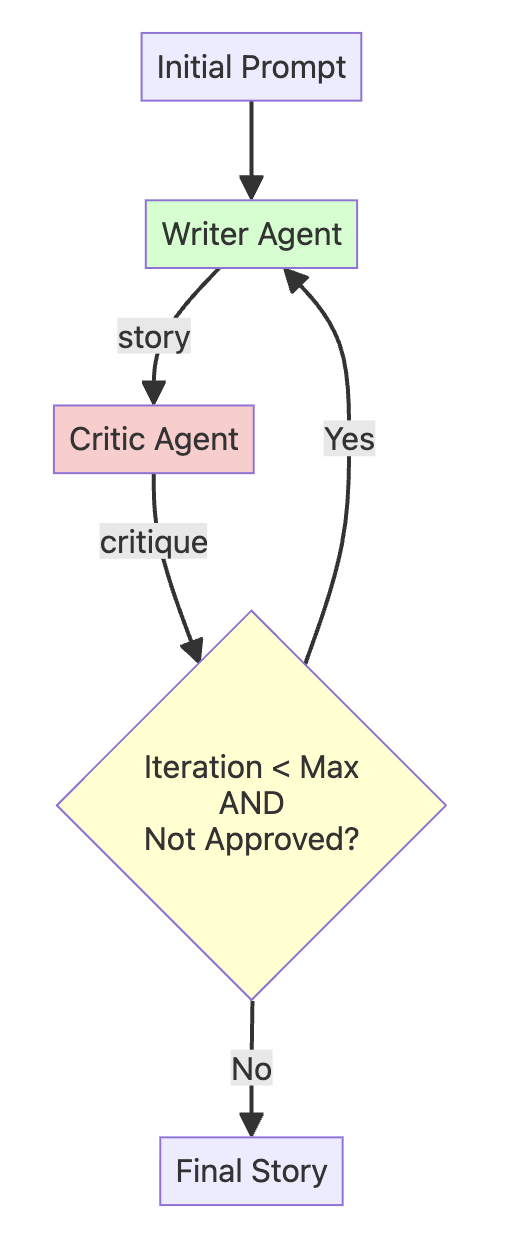

**Any Python function can become an agent tool** by 
following these simple guidelines:

1. Create a Python function
2. Follow the best practices listed below
3. Add your function to the agent's `tools=[]` list and ADK handles the rest automatically.


#### 🏆 ADK Best Practices in Action

Notice how our tools follow ADK best practices:

**1. Dictionary Returns**: Tools return `{"status": "success", "data": ...}` or `{"status": "error", "error_message": ...}`  
**2. Clear Docstrings**: LLMs use docstrings to understand when and how to use tools  
**3. Type Hints**: Enable ADK to generate proper schemas (`str`, `dict`, etc.)  
**4. Error Handling**: Structured error responses help LLMs handle failures gracefully  

These patterns make your tools reliable and easy for LLMs to use correctly.

In [31]:
def get_fee_for_payment_method(method: str) ->dict:
    """
    Looks up the transaction fee percentage for a given payment method.

    This tool simulates looking up a company's internal fee structure based on
    the name of the payment method provided by the user.

    Args:
        method: The name of the payment method. It should be descriptive,
                e.g., "platinum credit card" or "bank transfer".

    Returns:
        Dictionary with status and fee information.
        Success: {"status": "success", "fee_percentage": 0.02}
        Error: {"status": "error", "error_message": "Payment method not found"}
    """
    # This simulates looking up a company's internal fee structure.
    fee_database={
        "platinum credit card": 0.02,  # 2%
        "gold debit card": 0.035,  # 3.5%
        "bank transfer": 0.01,  # 1%
    }
    fee=fee_database.get(method.lower())
    if fee is not None:
        return { "status": "Success", "fee_percentage":fee}
    else:
        return { "status": "Error", "error_message":f"Payment method '{method}' is not found. "}

print(" Fee lookup function created")
print(f" Test: {get_fee_for_payment_method('Platinum credit card')}")

 Fee lookup function created
 Test: {'status': 'Success', 'fee_percentage': 0.02}


In [33]:
def get_exchange_rate(base_currency: str, target_currency: str)->dict:
    """Looks up and returns the exchange rate between two currencies.

    Args:
        base_currency: The ISO 4217 currency code of the currency you
                       are converting from (e.g., "USD").
        target_currency: The ISO 4217 currency code of the currency you
                         are converting to (e.g., "EUR").

    Returns:
        Dictionary with status and rate information.
        Success: {"status": "success", "rate": 0.93}
        Error: {"status": "error", "error_message": "Unsupported currency pair"}
    """
    # Static data simulating a live exchange rate API
    # In production, this would call something like: requests.get("api.exchangerates.com")
    rate_database = {
        "usd": {
            "eur": 0.93,  # Euro
            "jpy": 157.50,  # Japanese Yen
            "inr": 83.58,  # Indian Rupee
        }
    }
    
    base=base_currency.lower()
    target=target_currency.lower()
    
    rate=rate_database.get(base, {}).get(target)
    
    if rate is not None:
        return {"status": "success", "rate": rate}
    else:
        return {
            "status": "error",
            "error_message": f"Unsupported currency pair: {base_currency}/{target_currency}",
        }


print("Exchange rate function created")
print(f"Test: {get_exchange_rate('USD', 'EUR')}")


Exchange rate function created
Test: {'status': 'success', 'rate': 0.93}


In [39]:
# Currency agent with custom function tools
currency_agent=LlmAgent(
    name="currency_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a smart currency conversion assistant.

    For currency conversion requests:
    1. Use `get_fee_for_payment_method()` to find transaction fees
    2. Use `get_exchange_rate()` to get currency conversion rates
    3. Check the "status" field in each tool's response for errors
    4. Calculate the final amount after fees based on the output from `get_fee_for_payment_method` and `get_exchange_rate` methods and provide a clear breakdown.
    5. First, state the final converted amount.
        Then, explain how you got that result by showing the intermediate amounts. Your explanation must include: the fee percentage and its
        value in the original currency, the amount remaining after the fee, and the exchange rate used for the final conversion.

    If any tool returns status "error", explain the issue to the user clearly.
    """,
    tools=[get_fee_for_payment_method, get_exchange_rate]
)
print(" Currency agent created with custom function tools:\n 'get_fee_for_payment_method' and 'get_exchange_rate' ")

 Currency agent created with custom function tools:
 'get_fee_for_payment_method' and 'get_exchange_rate' 


In [40]:
currency_runner = InMemoryRunner(agent=currency_agent)
response= await currency_runner.run_debug(
    "I want to convert 500 US Dollars to Euros using my Platinum Credit Card. How much will I receive?"
)


 ### Created new session: debug_session_id

User > I want to convert 500 US Dollars to Euros using my Platinum Credit Card. How much will I receive?


currency_agent > The final converted amount is 455.7 EUR.

Here's how this amount was calculated:

1. **Fee deduction:** A fee of 2% is charged for using a platinum credit card. This amounts to 10.0 USD (500 USD * 0.02).
2. **Remaining amount:** After deducting the fee, 490.0 USD remains (500 USD - 10.0 USD).
3. **Currency conversion:** Using the exchange rate of 1 USD = 0.93 EUR, the remaining amount is converted to 455.7 EUR (490.0 USD * 0.93).


currency_agent > The final converted amount is 455.7 EUR.

Here's how this amount was calculated:

1. **Fee deduction:** A fee of 2% is charged for using a platinum credit card. This amounts to 10.0 USD (500 USD * 0.02).
2. **Remaining amount:** After deducting the fee, 490.0 USD remains (500 USD - 10.0 USD).
3. **Currency conversion:** Using the exchange rate of 1 USD = 0.93 EUR, the remaining amount is converted to 455.7 EUR (490.0 USD * 0.93).

# **Here, we define the custom tools for our agent. By using it our agent calculate the converted price.**